# Train Contextual Bandits with matrix-factorization-based simulation environment

> In this notebook, we'll evaluate the performance of Linear Contextual Bandits in an MF-based environment. This environment will accept contextual (per-arm) features about users and items

* Environment will compute a low-rank matrix factorization (using SVD) of the `<user, item>` data matrix
* Use the movielens dataset to formulate an approximate item rating for each user (collaborative filtering)
* Train a linear RL algorithm, the [LinUCB](https://www.tensorflow.org/agents/tutorials/intro_bandit) agent, which incorporates exploration via boosting the estimates by an amount that corresponds to the variance of those estimates

## background

**Simulation evnrionment**

the MF-based environment simulates real-world environment containing users and their respective preferences. Internally, the MovieLens simulation environment takes the user-by-movie-item rating matrix and performs a `RANK_K` matrix factorization on the rating matrix, in order to address the sparsity of the matrix. After this construction step, the environment can generate user vectors of dimension `RANK_K` to represent users in the simulation environment, and is able to determine the approximate reward for any user and movie item pair. In RL's language, user vectors are observations, recommended movie items are actions, and approximate ratings are rewards. This environment therefore defines the RL problem at hand: how to recommend movies that maximize user ratings, in a simulated world of users with their respective preferences defined by the MovieLens dataset, while having zero knowledge of the internal mechanism of the environment.

**Arm features**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.33.1


## Load env config

* use the prefix from `00-env-setup`

In [2]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

In [4]:
# ! gsutil ls $BUCKET_URI

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [7]:
import sys
sys.path.append("..")

# my project
from src.per_arm_rl import train_utils
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import trainer_baseline
from src.per_arm_rl import policy_util

### detect GPUs & reset devices

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [11]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### copy sample data to $DATA_PATH

### Load data config

In [12]:
# print(f"USER_AGE_LOOKUP: {data_config.USER_AGE_LOOKUP}")
# print(f"USER_AGE_DIM: {data_config.USER_AGE_DIM}")

# print(f"USER_OCC_LOOKUP: {data_config.USER_OCC_LOOKUP}")
# print(f"USER_OCC_DIM: {data_config.USER_OCC_DIM}")

# print(f"MOVIE_GEN_LOOKUP: {data_config.MOVIE_GEN_LOOKUP}")
# print(f"MOVIE_GEN_DIM: {data_config.MOVIE_GEN_DIM}")

# print(f"MOVIELENS_NUM_MOVIES: {data_config.MOVIELENS_NUM_MOVIES}")
# print(f"MOVIELENS_NUM_USERS: {data_config.MOVIELENS_NUM_USERS}")

In [13]:
# type(data_config.USER_OCC_LOOKUP)

### Read TF Records

In [14]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/', delimiter="/"): # {SPLIT}
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/ml-ratings-100k-full.tfrecord']

In [16]:
train_dataset = tf.data.TFRecordDataset(train_files)

train_dataset = train_dataset.map(data_utils.parse_tfrecord)

train_dataset

<_MapDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [17]:
for x in train_dataset.batch(1).take(2):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([45.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'357'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([879024327])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'138'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'doctor'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}
{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'709'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([875654590])>,
 'user_id': <tf.Tensor: shape=(1

# Define RL modules

In [18]:
# !pwd

# Train RL modules

## set hyperparameters

In [19]:
# Set hyperparameters.
BATCH_SIZE       = 128      # Training and prediction batch size.
# TRAINING_LOOPS   = 300     # Number of training iterations.
# STEPS_PER_LOOP   = 2      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 10     # Number of actions (movie items) to choose from.
PER_ARM          = True   # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
# print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
# print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 128
RANK_K           : 20
NUM_ACTIONS      : 10
PER_ARM          : True
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


## Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

> See `src.per_arm_rl.my_per_arm_py_env.py` for an example custom environment which implements a per-arm version of the MovieLens environment

In [20]:
from src.per_arm_rl import my_per_arm_py_env as my_per_arm_py_env

In [21]:
data_config.MOVIELENS_NUM_USERS

943

In [22]:
env = my_per_arm_py_env.MyMovieLensPerArmPyEnvironment(
    project_number = PROJECT_NUM
    , data_path = DATA_PATH
    , bucket_name = BUCKET_NAME
    , data_gcs_prefix = f"{DATA_GCS_PREFIX}"
    , user_age_lookup_dict = data_config.USER_AGE_LOOKUP
    , user_occ_lookup_dict = data_config.USER_OCC_LOOKUP
    , movie_gen_lookup_dict = data_config.MOVIE_GEN_LOOKUP
    , num_users = data_config.MOVIELENS_NUM_USERS
    , num_movies = data_config.MOVIELENS_NUM_MOVIES
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_actions = NUM_ACTIONS
)

environment = tf_py_environment.TFPyEnvironment(env)

In [23]:
# env.movie_gen_lookup_dict

In [24]:
# env.dataset

In [25]:
# env._user_occ_int

In [26]:
# environment.observation_spec()

In [27]:
# environment.time_step_spec()

In [28]:
# environment.action_spec()

## Define RL agent/algorithm

In [29]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec = environment.time_step_spec()
    , action_spec = environment.action_spec()
    , tikhonov_weight = TIKHONOV_WEIGHT
    , alpha = AGENT_ALPHA
    , dtype = tf.float32
    , accepts_per_arm_features = PER_ARM
    , summarize_grads_and_vars = True
    , enable_summaries = True
)

print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 21), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)) 

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



In [31]:
agent.initialize()

In [32]:
train_step_counter = tf.compat.v1.train.get_or_create_global_step()

saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=train_step_counter
)

#### The flow of training data

First, let us have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [37]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(21,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [38]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(22,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains, it does not need the per-arm features of all arms, it only needs those of the **chosen arm**. Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [39]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(21,), dtype=tf.float32, name=None)


## Define RL metrics

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [40]:
optimal_reward_fn = functools.partial(
    train_utils.compute_optimal_reward_with_my_environment
    , environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
regret_metric

In [41]:
optimal_action_fn = functools.partial(
    train_utils.compute_optimal_action_with_my_environment,
    environment=environment,
)
    
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
  optimal_action_fn
)
suboptimal_arms_metric

In [42]:
metrics = [regret_metric, suboptimal_arms_metric]
metrics

## Train (locally)

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### Define the training logic (on-policy training)

> The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py#L130) which also trains the policy.

### set Vertex Exeperiment

In [43]:
EXPERIMENT_NAME   = f'train-my-mf-env-{PREFIX}'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'gs://{BUCKET_NAME}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"                               # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"      

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : train-my-mf-env-rec-bandits-v2
RUN_NAME          : run-20231110-171058
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/train-my-mf-env-rec-bandits-v2/run-20231110-171058
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/train-my-mf-env-rec-bandits-v2/run-20231110-171058/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/train-my-mf-env-rec-bandits-v2/run-20231110-171058/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/train-my-mf-env-rec-bandits-v2/run-20231110-171058/artifacts


### Create TensorBoard

In [44]:
# # create new TB instance
TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}-{RUN_NAME}"

tensorboard = aiplatform.Tensorboard.create(
    display_name=TENSORBOARD_DISPLAY_NAME
    , project=PROJECT_ID
    , location=REGION
)

TB_RESOURCE_NAME = tensorboard.resource_name

TB_ID = TB_RESOURCE_NAME.split('/')[-1]

print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
print(f"TB display name  : {tensorboard.display_name}")
print(f"TB_ID            : {TB_ID}")

TB_RESOURCE_NAME : projects/934903580331/locations/us-central1/tensorboards/2473887968356466688
TB display name  : train-my-mf-env-rec-bandits-v2-run-20231110-171058
TB_ID            : 2473887968356466688


In [45]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    # experiment_tensorboard=TB_ID
)

### train RL agent

In [46]:
TRAINING_LOOPS   = 50     # Number of training iterations.
STEPS_PER_LOOP   = 1      # Number of driver steps per training iteration.

summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")

TRAINING_LOOPS   : 50
STEPS_PER_LOOP   : 1


In [47]:
TEST_HPT_FLAG  = False # True | False

_ARTIFACTS_DIR = ARTIFACTS_DIR if not TEST_HPT_FLAG else None
_ROOT_DIR      = ROOT_DIR if not TEST_HPT_FLAG else None

print(f"TEST_HPT_FLAG  : {TEST_HPT_FLAG}")
print(f"_ARTIFACTS_DIR : {_ARTIFACTS_DIR}")
print(f"_ROOT_DIR      : {_ROOT_DIR}")

TEST_HPT_FLAG  : True
_ARTIFACTS_DIR : None
_ROOT_DIR      : None


In [49]:
#start the timer and training
start_time = time.time()

metric_results = policy_util.train(
    agent=agent,
    environment=environment,
    log_dir=LOG_DIR,
    # model_dir = BASE_OUTPUT_DIR,
    chkpt_dir = f"{BASE_OUTPUT_DIR}/chkpts",
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    # save_policy=True,
    artifacts_dir=_ARTIFACTS_DIR,
    root_dir=_ROOT_DIR,
    run_hyperparameter_tuning=TEST_HPT_FLAG,
    profiler = False,
    train_summary_writer = summary_writer,
    chkpt_interval = 10
)


end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

step = 0: train loss = 0.6100000143051147
step = 10: train loss = 0.8199999928474426
step = 20: train loss = 0.9300000071525574
step = 30: train loss = 1.0099999904632568
step = 40: train loss = 1.190000057220459
train runtime_mins: 2


In [52]:
pprint(metric_results.keys())

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])


In [57]:
# metric_results['AverageReturnMetric']

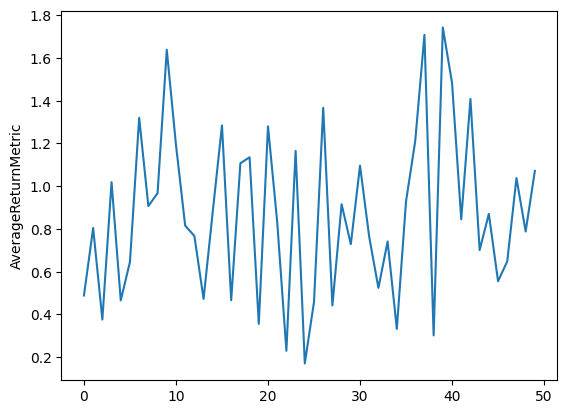

In [58]:
import matplotlib.pyplot as plt

plt.plot(metric_results['AverageReturnMetric'])
plt.ylabel('AverageReturnMetric')
plt.show()

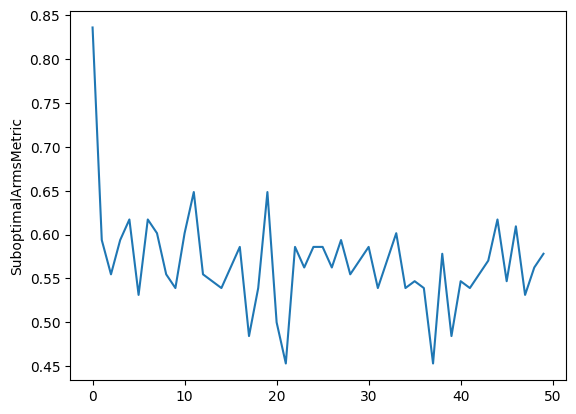

In [59]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

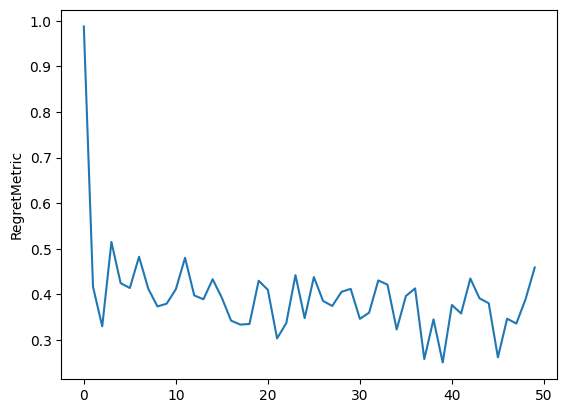

In [60]:
plt.plot(metric_results['RegretMetric'])
plt.ylabel('RegretMetric')
plt.show()

### TensorBoard

In [44]:
# %load_ext tensorboard
%reload_ext tensorboard

In [45]:
%tensorboard --logdir=$LOG_DIR

### load trained policy

In [79]:
# !gsutil ls $ARTIFACTS_DIR

In [70]:
# trained_policy = tf.saved_model.load(ARTIFACTS_DIR)
# trained_policy

# Debugging notes

In [ ]:
# # Continuous monitoring
# aiplatform.start_upload_tb_log(
#     # tensorboard_id=TB_RESOURCE_NAME,
#     tensorboard_experiment_name=EXPERIMENT_NAME,
#     logdir=LOG_DIR,
#     experiment_display_name=EXPERIMENT_NAME,
#     run_name_prefix=RUN_NAME,
#     # description=description,
# )
    
# #start the timer and training
# start_time = time.time()

# metric_results = trainer_baseline.train(
#     # root_dir=LOG_DIR,
#     artifact_dir=ARTIFACTS_DIR,
#     log_dir=LOG_DIR,
#     agent=agent,
#     environment=environment,
#     training_loops=TRAINING_LOOPS,
#     steps_per_loop=STEPS_PER_LOOP,
#     additional_metrics=metrics,
#     save_policy=True
# )

# aiplatform.end_upload_tb_log()

# end_time = time.time()
# runtime_mins = int((end_time - start_time) / 60)
# print(f"train runtime_mins: {runtime_mins}")

In [73]:
environment._u_hat

sampled_user_ages = np.ones(BATCH_SIZE)
sampled_user_occ = np.ones(BATCH_SIZE)

SAMPLED_USER_INDICES = np.random.randint(data_config.MOVIELENS_NUM_USERS, size=BATCH_SIZE)
SAMPLED_USER_INDICES

combined_user_features = np.concatenate(
    (
        environment._u_hat[SAMPLED_USER_INDICES]
        , sampled_user_ages.reshape(-1,1)
        , sampled_user_occ.reshape(-1,1)
    )
    , axis=1
)

In [74]:
SAMPLED_USER_INDICES

array([161, 765, 664, 855, 878,  14,  56, 321, 887, 754, 884,  69, 473,
        56, 136, 241, 758, 513, 319,  12, 132, 382, 684, 857, 675, 527,
       569,  46, 129, 424, 179, 392, 210, 313, 759, 244, 458, 467, 820,
       185, 169, 287, 718, 889, 426, 241, 549,  99, 704, 110, 287, 438,
       837, 336, 586, 290,  84, 475, 887,  21, 586,  97, 258,  22, 343,
       916, 562,  34, 741, 266, 557, 514, 362,  53, 730, 532,  99, 852,
       571, 940, 392, 762, 443, 278, 666, 202,  59, 481, 198, 262, 892,
       690, 790, 746, 761, 749, 308,  37,  80, 370, 781, 136, 217, 646,
       137, 827, 183, 366, 433, 874, 560, 839, 293, 689, 461, 113, 297,
       476, 660, 438, 562, 344, 126, 760, 481, 857, 414, 728])

In [75]:
sampled_u_hats_pred = environment._u_hat[SAMPLED_USER_INDICES]
sampled_u_hats_pred

array([[-0.01291269, -0.02463202, -0.00912144, ..., -0.02481789,
         0.00289364,  0.01819377],
       [-0.04131135,  0.06962406, -0.00452757, ..., -0.02675546,
        -0.02063719, -0.02562911],
       [-0.03796224, -0.03537715, -0.00614115, ...,  0.0305048 ,
        -0.03006611, -0.01280255],
       ...,
       [-0.00444794, -0.01411317,  0.01979582, ...,  0.02230501,
         0.01115231, -0.00133995],
       [-0.00854008,  0.00115751,  0.00909269, ...,  0.02653135,
         0.00677221, -0.00530296],
       [-0.00273581, -0.0172236 ,  0.01085442, ...,  0.00161616,
         0.01074529,  0.0073932 ]], dtype=float32)

In [76]:
environment._u_hat

array([[-0.0658043 ,  0.00597506, -0.00613256, ...,  0.01743993,
        -0.03573092,  0.03894605],
       [-0.01402104, -0.04662602,  0.05257856, ...,  0.01171281,
         0.01670101, -0.01658576],
       [-0.00565798, -0.02561845,  0.02336183, ..., -0.01843041,
        -0.02539826, -0.0020144 ],
       ...,
       [-0.00744452, -0.02502129,  0.00616532, ..., -0.03812664,
         0.03884653,  0.01103627],
       [-0.02403119,  0.00809611,  0.02288736, ..., -0.0200555 ,
         0.00571077, -0.00570774],
       [-0.04224209, -0.01092715, -0.05854604, ...,  0.02310407,
        -0.03948996, -0.0340745 ]], dtype=float32)

In [78]:
# # user_ids_pred = np.array([1,2,3,4,5,6,7])
# user_age_pred = np.array([1,1,1,1,1,1,1,1])
# user_occ_pred = np.array([1,1,1,1,1,1,1,1])

# combined_user_features = np.concatenate(
#     (
#         # user_ids_pred
#         sampled_u_hats_pred
#         , user_age_pred.reshape(-1,1)
#         , user_occ_pred.reshape(-1,1)
#     )
#     , axis=1
# )

# combined_user_features.shape